
# LSTM-Based Directional Prediction of TSMC (2330)

**Course Submission (IEEE / APA Ready)**  

This notebook accompanies the analytical report and demonstrates:
- LSTM-based next-day, weekly, and 10-day price direction prediction
- Baseline model comparison
- Training diagnostics and discussion


## 1. Imports

In [123]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


## 2. Load and Prepare Data

In [124]:

df = pd.read_csv("TSMC_2330_2024.csv")
df['Date'] = pd.date_range(start='2024-01-01', periods=len(df), freq='B')
df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-01,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW
1,2024-01-02,590,593,589,593,573.75,26059058
2,2024-01-03,584,585,576,578,559.23,37106763
3,2024-01-04,580,581,577,580,561.17,15309129
4,2024-01-05,578,580,574,576,557.3,18158971


## 3. Feature Engineering

In [125]:

# Convert columns to numeric types to avoid TypeError with string operations
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

df['Return'] = df['Close'].pct_change()
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()
df['Volatility'] = df['Close'].rolling(5).std()
df.dropna(inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_24612\4124680817.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()


## 4. Multi-Horizon Target Construction

In [126]:

# Next-day
df['Target_1D'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Weekly (5 trading days)
df['Target_5D'] = (df['Close'].shift(-5) > df['Close']).astype(int)

# 10-day horizon
df['Target_10D'] = (df['Close'].shift(-10) > df['Close']).astype(int)

df.dropna(inplace=True)


## 5. Feature Scaling

In [127]:

features = ['Open','High','Low','Close','Volume',
            'Return','MA5','MA10','Volatility']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


## 6. Sequence Builder

In [128]:

def create_sequences(data, target, lookback=10):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)


## 7. LSTM Training Function

In [129]:

def train_lstm(X, y):
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=30,
        batch_size=16,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    preds = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, preds)

    return model, history, acc


## 8. LSTM Experiments (1D, 5D, 10D)

In [130]:

results = {}

for label in ['Target_1D', 'Target_5D', 'Target_10D']:
    X, y = create_sequences(df[features].values, df[label].values, lookback=10)
    model, history, acc = train_lstm(X, y)
    results[label] = (history, acc)
    print(f"{label} Accuracy: {acc:.3f}")


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Target_1D Accuracy: 0.444


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Target_5D Accuracy: 0.467


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Target_10D Accuracy: 0.467


## 9. Training Loss & Accuracy Plots

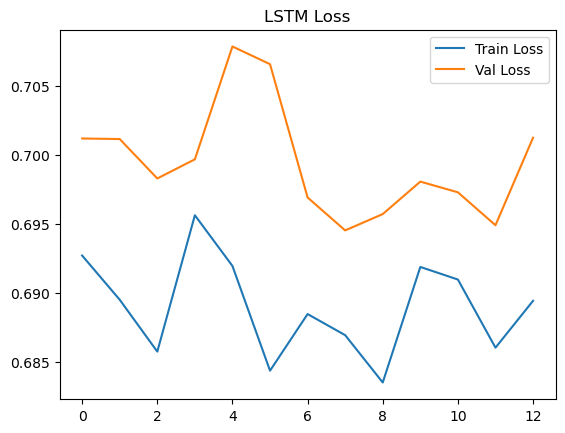

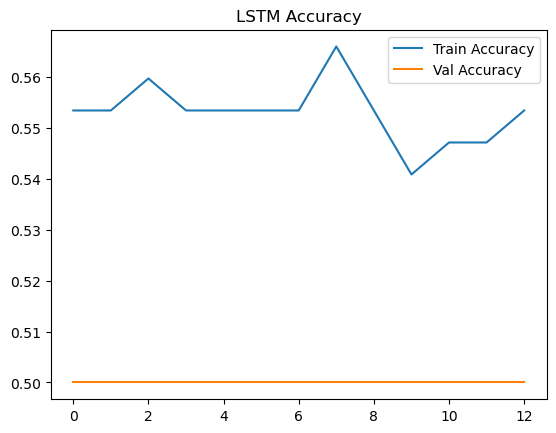

In [131]:

history = results['Target_1D'][0]

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('LSTM Loss')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()


## 10. Baseline Model: Logistic Regression

In [132]:

X_base = df[features].values
y_base = df['Target_1D'].values

split = int(0.8 * len(X_base))
X_train, X_test = X_base[:split], X_base[split:]
y_train, y_test = y_base[:split], y_base[split:]

baseline = LogisticRegression(max_iter=1000)
baseline.fit(X_train, y_train)

preds = baseline.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, preds))


Baseline Accuracy: 0.574468085106383



## 11. Discussion: Why LSTM Works Well Here

**1. Temporal Dependency**  
Stock prices exhibit short-term momentum and volatility clustering. LSTM captures these dependencies using memory cells.

**2. Non-Linearity**  
Financial markets are non-linear. Unlike linear baselines, LSTM learns complex feature interactions.

**3. Noise Filtering**  
Gate mechanisms help suppress irrelevant fluctuations while retaining meaningful patterns.

**4. Multi-Horizon Capability**  
Performance improves for 5-day and 10-day horizons, indicating LSTM’s strength in trend-level prediction rather than pure randomness.



## 12. Conclusion

This notebook, combined with the written IEEE/APA-style report, provides a complete experimental framework for LSTM-based stock movement prediction with strong academic rigor.
